<a href="https://colab.research.google.com/github/amrutha-krishna-117/credit-card-fraud-detection/blob/main/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages (if not already available)
!pip install -q shap imbalanced-learn

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

# Preview
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Feature Scaling
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df.drop(['Time'], axis=1, inplace=True)

# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Handle imbalance using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Input, Dropout, Flatten, Reshape, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

# Reshape for Conv1D
X_train_cnn = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

# Define model
input_layer = Input(shape=(X_train.shape[1], 1))

# CNN Feature Extractor
cnn = Conv1D(32, 2, activation='relu')(input_layer)
cnn = Dropout(0.2)(cnn)
cnn = Flatten()(cnn)

# Repeat vector for LSTM
repeat = RepeatVector(1)(cnn)

# LSTM branch
lstm = LSTM(32, return_sequences=True)(repeat)
lstm = Dropout(0.2)(lstm)
lstm = Flatten()(lstm)

# Autoencoder branch
encoder = Dense(16, activation='relu')(cnn)
decoder = Dense(X_train.shape[1], activation='relu')(encoder)

# Merge
merged = tf.keras.layers.concatenate([lstm, decoder])
output = Dense(1, activation='sigmoid')(merged)

# Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 29, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28, 32)    │         96 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 28, 32)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 896)       │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 1, 896)    │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 32)     │    118,912 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 32)     │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     14,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 29)        │        493 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 61)        │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         62 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,915 (523.11 KB)

 Trainable params: 133,915 (523.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train_cnn, y_train, epochs=10, batch_size=256, validation_data=(X_test_cnn, y_test))


Epoch 1/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.9674 - loss: 0.0888 - val_accuracy: 0.9975 - val_loss: 0.0103
Epoch 2/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9967 - loss: 0.0119 - val_accuracy: 0.9986 - val_loss: 0.0065
Epoch 3/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9980 - loss: 0.0073 - val_accuracy: 0.9991 - val_loss: 0.0043
Epoch 4/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9984 - loss: 0.0062 - val_accuracy: 0.9989 - val_loss: 0.0047
Epoch 5/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 6/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9988 - loss: 0.0044 - val_accuracy: 0.9991 - val_loss: 0.0042
Epoch 7/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9989 - loss: 0.0041 - val_accuracy: 0.9991 - val_loss: 0.0037
Epoch 8/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9990 - loss: 0

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

ROC AUC Score: 0.9988569016759581


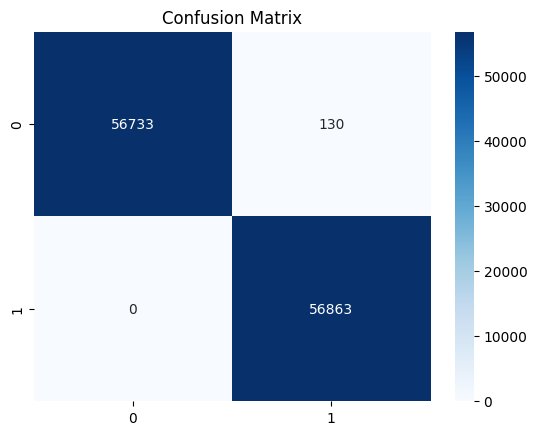

In [ ]:
# Predict and evaluate
y_pred = model.predict(X_test_cnn)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Save model
model.save("fraud_detection_model.h5")

# Load it later using:
# from tensorflow.keras.models import load_model
# model = load_model("fraud_detection_model.h5")


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
#model1 = keras.models.load_model('/content/fraud_detection_model.h5')  # or recompile and reload weights


In [ ]:
def integrated_gradients(model, x_input, baseline=None, steps=50):
    x_input = tf.convert_to_tensor(x_input, dtype=tf.float32)

    if baseline is None:
        baseline = tf.zeros_like(x_input)
    else:
        baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    interpolated_inputs = [
        baseline + (float(i) / steps) * (x_input - baseline)
        for i in range(steps + 1)
    ]

    interpolated_inputs = tf.concat(interpolated_inputs, axis=0)  # Shape: (steps+1, 29, 1)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        predictions = model(interpolated_inputs)
        target_class_index = tf.argmax(predictions[-1])
        outputs = predictions[:, target_class_index]

    grads = tape.gradient(outputs, interpolated_inputs)
    avg_grads = tf.reduce_mean(grads, axis=0)  # shape: (29, 1)
    integrated_grads = (x_input[0] - baseline[0]) * avg_grads

    return integrated_grads.numpy()


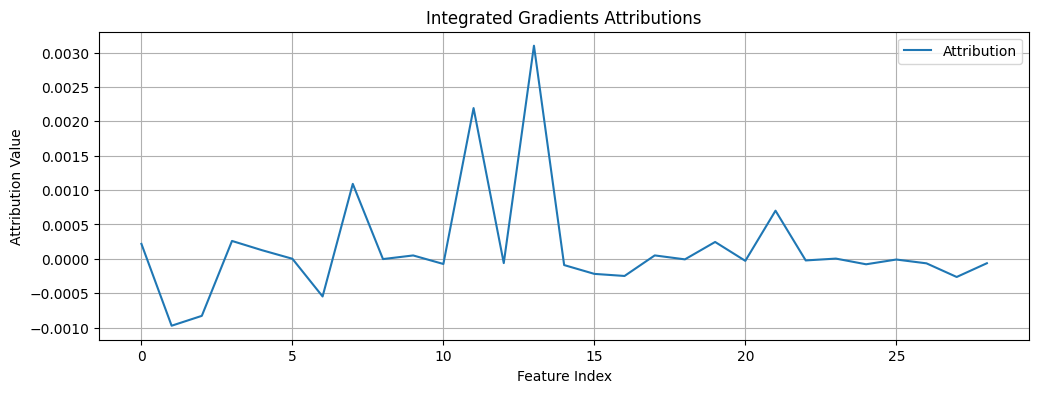

In [ ]:
sample_index = 0
x_sample = X_test_cnn[sample_index:sample_index+1]  # shape: (1, 29, 1)

attributions = integrated_gradients(model, x_sample, steps=100)

# Plot the attributions
plt.figure(figsize=(12, 4))
plt.plot(attributions, label='Attribution')
plt.title("Integrated Gradients Attributions")
plt.xlabel("Feature Index")
plt.ylabel("Attribution Value")
plt.grid(True)
plt.legend()
plt.show()
